# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

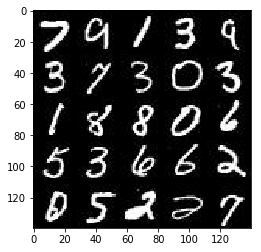

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

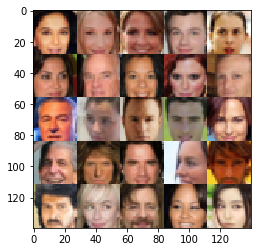

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28*3 -> 14*14*64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2*x1, x1)
        
        # 14*14*64 -> 7*7*128
        x2 = tf.layers.conv2d(x1, 128, 5, strides =2 , padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2*x2, x2)
        
        # 7*7*128 -> 3*3*256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2*x3, x3)
        
        # flatten 
        s = x3.get_shape().as_list()
        flat = tf.reshape(x3, (-1, s[1]*s[2]*s[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    if is_train == True:
        reuse = False
    with tf.variable_scope('generator', reuse=reuse):
        # z_dim -> 7*7*256
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        
        # 7*7*256 -> 14*14*128
        x2 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2*x2, x2)
        
        # 14*14*128 -> 28*28*64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2*x3, x3)
        
        # 28*28*64 -> 28*28*3
        logits = tf.layers.conv2d(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vts = tf.trainable_variables()
    d_v = [v for v in vts if v.name.startswith('discriminator')]
    g_v = [v for v in vts if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        # TODO: Build Model
    tf.reset_default_graph()
    (_, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 3
    show_every = epoch_count*100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer 
                _= sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                _= sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 3.1293... Generator Loss: 0.0698
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 2.4732... Generator Loss: 2.9048
Epoch 1/2... Discriminator Loss: 1.9152... Generator Loss: 0.2963
Epoch 1/2... Discriminator Loss: 1.7612... Generator Loss: 0.2519
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 2.0519... Generator Loss: 0.2026
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.4989
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 1.8786
Epoch 1/2.

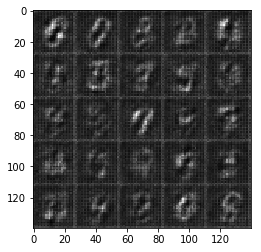

Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 1.2346
Epoch 1/2... Discriminator Loss: 0.0314... Generator Loss: 5.4279
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 0.1615... Generator Loss: 3.4549
Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 2.5490
Epoch 1/2... Discriminator Loss: 0.3778... Generator Loss: 3.0819
Epoch 1/2... Discriminator Loss: 0.5564... Generator Loss: 2.8229
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 4.7572
Epoch 1/2... Discriminator Loss: 0.0566... Generator Loss: 5.0207
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 0.3058... Generator Loss: 4.3854
Epoch 1/2... Discriminator Loss: 0.3213... Generator Loss: 2.0646
Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 1.9039
Epoch 1/2... Discriminator Loss: 0.0431... Generator Loss: 6.8389
Epoch 1/2.

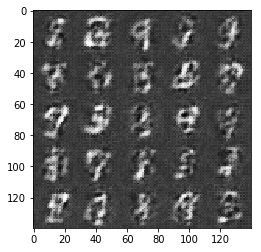

Epoch 1/2... Discriminator Loss: 0.0688... Generator Loss: 4.2122
Epoch 1/2... Discriminator Loss: 0.2057... Generator Loss: 2.1608
Epoch 1/2... Discriminator Loss: 0.0398... Generator Loss: 4.5876
Epoch 1/2... Discriminator Loss: 1.9714... Generator Loss: 0.2055
Epoch 1/2... Discriminator Loss: 0.2697... Generator Loss: 1.9050
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 0.1153... Generator Loss: 2.8756
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 4.5087
Epoch 1/2... Discriminator Loss: 0.4302... Generator Loss: 2.5483
Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 5.8644
Epoch 1/2... Discriminator Loss: 0.1614... Generator Loss: 2.7529
Epoch 1/2... Discriminator Loss: 0.1142... Generator Loss: 6.6509
Epoch 1/2... Discriminator Loss: 0.0899... Generator Loss: 3.5305
Epoch 1/2... Discriminator Loss: 0.1504... Generator Loss: 2.6430
Epoch 1/2... Discriminator Loss: 0.1210... Generator Loss: 2.5657
Epoch 1/2.

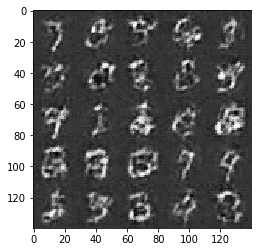

Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 1.1648
Epoch 1/2... Discriminator Loss: 2.7220... Generator Loss: 0.0869
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 0.8590
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 5.6872
Epoch 1/2... Discriminator Loss: 0.5099... Generator Loss: 2.4633
Epoch 1/2... Discriminator Loss: 0.2638... Generator Loss: 1.9769
Epoch 1/2... Discriminator Loss: 0.2611... Generator Loss: 2.0774
Epoch 1/2... Discriminator Loss: 0.1443... Generator Loss: 2.6629
Epoch 1/2... Discriminator Loss: 0.1165... Generator Loss: 3.0489
Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 3.1218
Epoch 1/2... Discriminator Loss: 0.1007... Generator Loss: 2.9805
Epoch 1/2... Discriminator Loss: 0.1102... Generator Loss: 2.8095
Epoch 1/2... Discriminator Loss: 0.0654... Generator Loss: 3.5792
Epoch 1/2... Discriminator Loss: 0.0762... Generator Loss: 3.3206
Epoch 1/2... Discriminator Loss: 0.0912... Generator Loss: 3.0939
Epoch 1/2.

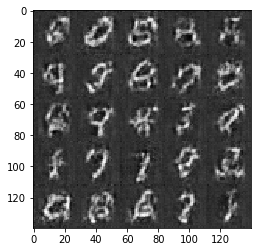

Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 1.4174
Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 1.1997
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 1.5387
Epoch 1/2... Discriminator Loss: 0.4172... Generator Loss: 1.5051
Epoch 1/2... Discriminator Loss: 0.3315... Generator Loss: 1.7412
Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 1.6923
Epoch 1/2... Discriminator Loss: 0.4860... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 0.2162... Generator Loss: 2.1548
Epoch 1/2... Discriminator Loss: 0.3238... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 1.5167
Epoch 1/2... Discriminator Loss: 0.3610... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 0.1758... Generator Loss: 2.4120
Epoch 1/2... Discriminator Loss: 0.2201... Generator Loss: 2.1147
Epoch 1/2... Discriminator Loss: 0.1791... Generator Loss: 2.6534
Epoch 1/2.

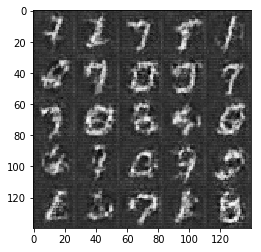

Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.5944
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 0.4952... Generator Loss: 2.5412
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 1.9181
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 1.5239
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 1.6755
Epoch 2/2... Discriminator Loss: 0.3113... Generator Loss: 1.6919
Epoch 2/2... Discriminator Loss: 0.3234... Generator Loss: 1.7099
Epoch 2/2... Discriminator Loss: 0.2824... Generator Loss: 1.9157
Epoch 2/2... Discriminator Loss: 0.3201... Generator Loss: 1.8475
Epoch 2/2... Discriminator Loss: 0.3519... Generator Loss: 1.5559
Epoch 2/2... Discriminator Loss: 0.2327... Generator Loss: 2.0305
Epoch 2/2.

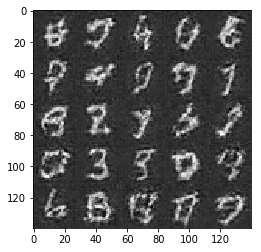

Epoch 2/2... Discriminator Loss: 0.2133... Generator Loss: 1.9774
Epoch 2/2... Discriminator Loss: 0.0917... Generator Loss: 3.2313
Epoch 2/2... Discriminator Loss: 0.1318... Generator Loss: 2.4998
Epoch 2/2... Discriminator Loss: 0.1604... Generator Loss: 2.5662
Epoch 2/2... Discriminator Loss: 0.2094... Generator Loss: 2.0199
Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 3.8198
Epoch 2/2... Discriminator Loss: 0.0675... Generator Loss: 3.4561
Epoch 2/2... Discriminator Loss: 0.1731... Generator Loss: 4.5259
Epoch 2/2... Discriminator Loss: 0.2188... Generator Loss: 4.1042
Epoch 2/2... Discriminator Loss: 0.2649... Generator Loss: 1.9079
Epoch 2/2... Discriminator Loss: 0.3019... Generator Loss: 1.6878
Epoch 2/2... Discriminator Loss: 0.0659... Generator Loss: 3.2545
Epoch 2/2... Discriminator Loss: 0.2032... Generator Loss: 2.0470
Epoch 2/2... Discriminator Loss: 0.0681... Generator Loss: 3.2480
Epoch 2/2... Discriminator Loss: 0.3314... Generator Loss: 1.4937
Epoch 2/2.

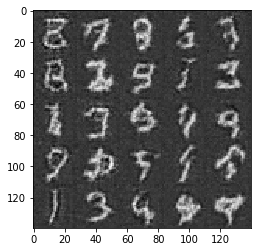

Epoch 2/2... Discriminator Loss: 0.2749... Generator Loss: 2.1433
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 0.3198... Generator Loss: 2.3977
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 2.5096
Epoch 2/2... Discriminator Loss: 1.4984... Generator Loss: 0.3657
Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 0.2749... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.6081
Epoch 2/2... Discriminator Loss: 0.2048... Generator Loss: 2.3298
Epoch 2/2... Discriminator Loss: 0.2911... Generator Loss: 2.2538
Epoch 2/2... Discriminator Loss: 0.2042... Generator Loss: 2.3274
Epoch 2/2... Discriminator Loss: 0.2327... Generator Loss: 2.0451
Epoch 2/2... Discriminator Loss: 0.2846... Generator Loss: 1.6335
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.3313
Epoch 2/2... Discriminator Loss: 0.3670... Generator Loss: 1.3954
Epoch 2/2.

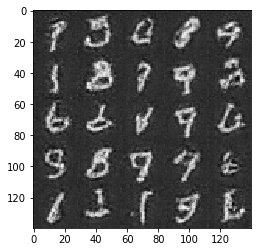

Epoch 2/2... Discriminator Loss: 0.0535... Generator Loss: 3.5965
Epoch 2/2... Discriminator Loss: 0.0755... Generator Loss: 5.7357
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 1.5175
Epoch 2/2... Discriminator Loss: 0.1398... Generator Loss: 2.4755
Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 3.6550
Epoch 2/2... Discriminator Loss: 0.1748... Generator Loss: 2.1469
Epoch 2/2... Discriminator Loss: 0.2128... Generator Loss: 1.9413
Epoch 2/2... Discriminator Loss: 0.0860... Generator Loss: 2.8452
Epoch 2/2... Discriminator Loss: 0.1172... Generator Loss: 2.5510
Epoch 2/2... Discriminator Loss: 0.1315... Generator Loss: 2.5293
Epoch 2/2... Discriminator Loss: 0.1278... Generator Loss: 2.3964
Epoch 2/2... Discriminator Loss: 0.0624... Generator Loss: 3.3859
Epoch 2/2... Discriminator Loss: 0.1196... Generator Loss: 2.5066
Epoch 2/2... Discriminator Loss: 0.0260... Generator Loss: 5.8125
Epoch 2/2... Discriminator Loss: 0.0534... Generator Loss: 3.6200
Epoch 2/2.

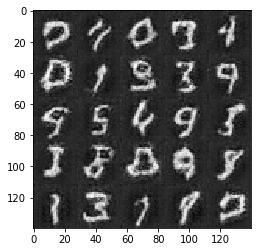

Epoch 2/2... Discriminator Loss: 6.8862... Generator Loss: 9.7039
Epoch 2/2... Discriminator Loss: 1.6203... Generator Loss: 0.4361
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.4465
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.5570
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 1.4957
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.1878
Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 2.0612
Epoch 2/2... Discriminator Loss: 0.4011... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.2603... Generator Loss: 2.1030
Epoch 2/2... Discriminator Loss: 0.3186... Generator Loss: 1.9060
Epoch 2/2... Discriminator Loss: 0.3978... Generator Loss: 1.4017
Epoch 2/2... Discriminator Loss: 0.2471... Generator Loss: 1.8824
Epoch 2/2... Discriminator Loss: 0.2178... Generator Loss: 2.2427
Epoch 2/2.

IndexError: list index out of range

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 1.8497
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 2.6694
Epoch 1/1... Discriminator Loss: 0.3237... Generator Loss: 2.3730
Epoch 1/1... Discriminator Loss: 0.2680... Generator Loss: 2.4996
Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 3.7433
Epoch 1/1... Discriminator Loss: 0.2499... Generator Loss: 2.9560
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 0.3108... Generator Loss: 3.4881
Epoch 1/1... Discriminator Loss: 0.3081... Generator Loss: 2.3163
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 2.3950... Generator Loss: 9.0440
Epoch 1/1... Discriminator Loss: 0.2070... Generator Loss: 3.4884
Epoch 1/1.

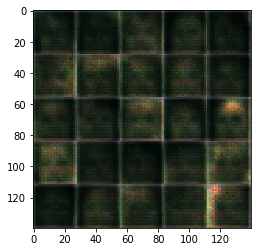

Epoch 1/1... Discriminator Loss: 0.0506... Generator Loss: 3.9084
Epoch 1/1... Discriminator Loss: 0.0678... Generator Loss: 3.6860
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 3.8001
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 4.5808
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 3.8494
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 4.1826
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 4.6761
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 6.7353
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 7.3663
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 4.0940
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 6.2153
Epoch 1/1... Discriminator Loss: 0.0718... Generator Loss: 3.8726
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 2.9938
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 5.5218
Epoch 1/1... Discriminator Loss: 0.1630... Generator Loss: 6.9811
Epoch 1/1.

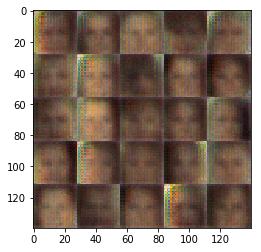

Epoch 1/1... Discriminator Loss: 2.0391... Generator Loss: 0.2451
Epoch 1/1... Discriminator Loss: 2.4000... Generator Loss: 0.2363
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 2.4894
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 2.4394
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 9.6203
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 8.1813
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 5.2107
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 2.5909
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 5.9484
Epoch 1/1.

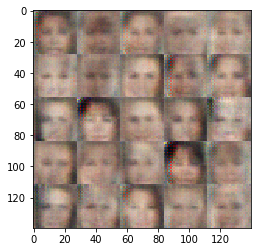

Epoch 1/1... Discriminator Loss: 0.2091... Generator Loss: 2.7218
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 8.3797
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 8.0882
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 8.8106
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 8.9574
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 5.4694
Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 8.5446
Epoch 1/1... Discriminator Loss: 0.2646... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 0.2128... Generator Loss: 2.3304
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 7.9653
Epoch 1/1... Discriminator Loss: 0.2080... Generator Loss: 2.5615
Epoch 1/1... Discriminator Loss: 0.0431... Generator Loss: 7.7509
Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 0.2309... Generator Loss: 10.4477
Epoch 1/1... Discriminator Loss: 0.0990... Generator Loss: 3.3348
Epoch 1/1

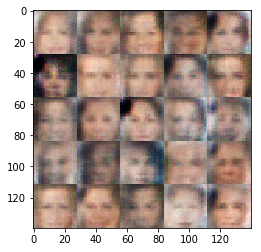

Epoch 1/1... Discriminator Loss: 0.1465... Generator Loss: 2.4596
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 5.5397
Epoch 1/1... Discriminator Loss: 0.1177... Generator Loss: 3.7146
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 2.7543
Epoch 1/1... Discriminator Loss: 2.2686... Generator Loss: 9.0539
Epoch 1/1... Discriminator Loss: 1.7420... Generator Loss: 10.1046
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 8.0091
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 0.2531... Generator Loss: 2.2755
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 8.4456
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 5.4531
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 3.3657
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 3.2529
Epoch 1/1

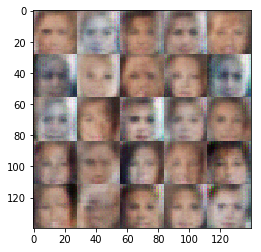

Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 7.2907
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 4.7026
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 3.1324
Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 4.8210
Epoch 1/1... Discriminator Loss: 0.1665... Generator Loss: 2.6741
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 12.4022
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 10.7932
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 1.5081
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 9.1824
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 7.7987
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 10.6508
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 7.3095
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 4.2405
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 8.0476
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 9.1524
Epoch 1

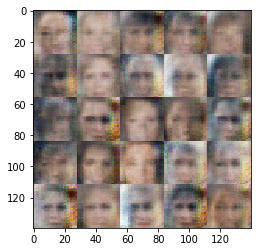

Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 11.1045
Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 8.3745
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 4.2541
Epoch 1/1... Discriminator Loss: 5.1927... Generator Loss: 0.1437
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 4.7505
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 4.4855
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.6262
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 2.6500
Epoch 1/1... Discriminator Loss: 0.2883... Generator Loss: 6.4472
Epoch 1/1... Discriminator Loss: 0.0665... Generator Loss: 7.0962
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 6.7428
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 6.5956
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 6.5771
Epoch 1/1

IndexError: list index out of range

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.